## Setup

In [23]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [24]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
task = 'BlockTableRedGrab'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [26]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [ ]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

In [ ]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=1,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [ ]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-07-21 22:34:47.886 | INFO     |  Fitting AutoTPGMM
2025-07-21 22:34:47.886 | INFO     |  Performing fitting actions: [INIT]
2025-07-21 22:34:47.886 | INFO     |  Segmenting trajectories


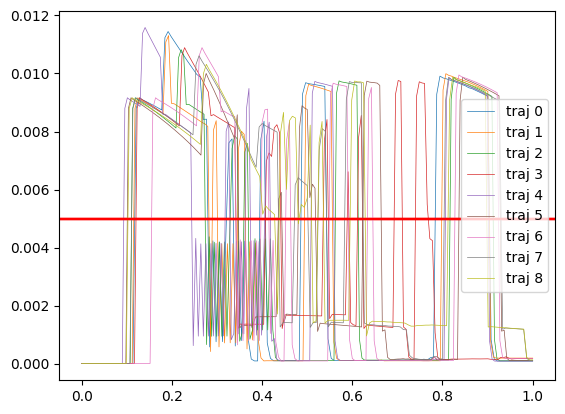

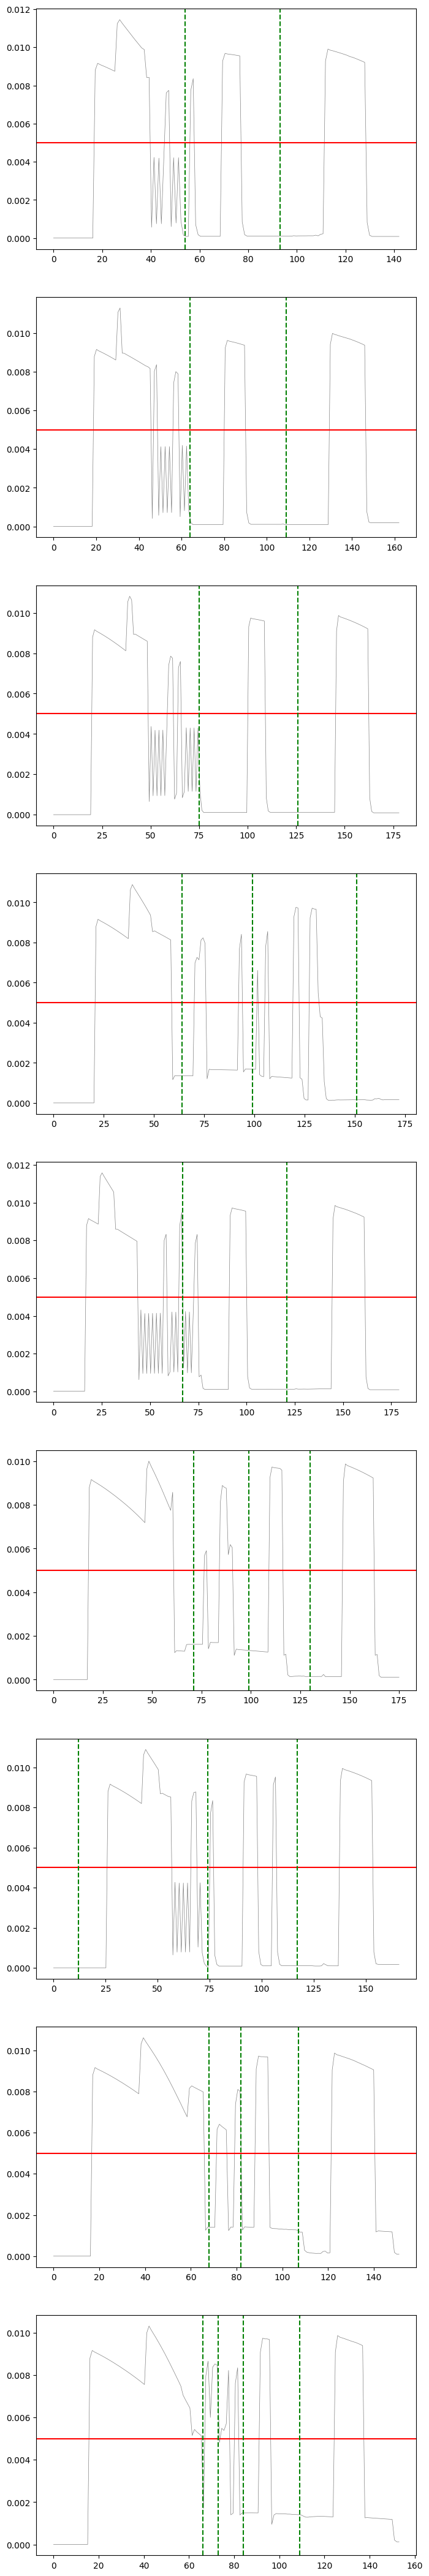

2025-07-21 22:34:50.309 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(151, dtype=torch.int32),) from traj 3 of len 172
2025-07-21 22:34:50.310 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(130, dtype=torch.int32),) from traj 5 of len 175
2025-07-21 22:34:50.311 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(117, dtype=torch.int32),) from traj 6 of len 166
2025-07-21 22:34:50.311 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(107, dtype=torch.int32),) from traj 7 of len 151
2025-07-21 22:34:50.312 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because 

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.384 | INFO     |    Fitting candidate frame 2/10
2025-07-21 22:34:50.385 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.435 | INFO     |    Fitting candidate frame 3/10
2025-07-21 22:34:50.435 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.474 | INFO     |    Fitting candidate frame 4/10
2025-07-21 22:34:50.475 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.514 | INFO     |    Fitting candidate frame 5/10
2025-07-21 22:34:50.515 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.570 | INFO     |    Fitting candidate frame 6/10
2025-07-21 22:34:50.571 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.651 | INFO     |    Fitting candidate frame 7/10
2025-07-21 22:34:50.653 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.737 | INFO     |    Fitting candidate frame 8/10
2025-07-21 22:34:50.741 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.862 | INFO     |    Fitting candidate frame 9/10
2025-07-21 22:34:50.862 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.931 | INFO     |    Fitting candidate frame 10/10
2025-07-21 22:34:50.932 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:50.983 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-07-21 22:34:50.983 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-07-21 22:34:50.983 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-07-21 22:34:50.983 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-07-21 22:34:50.984 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-07-21 22:34:50.984 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-07-21 22:34:50.984 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-07-21 22:34:50.984 | INFO     |  obj006     score (rel):     -0 (0.205)
2025-07-21 22:34:50.984 | INFO     |  obj007     score (rel):     -0 (0.005)
2025-07-21 22:34:50.984 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-07-21 22:34:50.985 | INFO     |  Creating partial frame view of demos.
2025-07-21 22:34:51.103 | INFO     |    Fitting candidate frame 1/10
2025-07-21 22:34:51.104 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.142 | INFO     |    Fitting candidate frame 2/10
2025-07-21 22:34:51.143 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.205 | INFO     |    Fitting candidate frame 3/10
2025-07-21 22:34:51.205 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.289 | INFO     |    Fitting candidate frame 4/10
2025-07-21 22:34:51.290 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.372 | INFO     |    Fitting candidate frame 5/10
2025-07-21 22:34:51.373 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.462 | INFO     |    Fitting candidate frame 6/10
2025-07-21 22:34:51.463 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.526 | INFO     |    Fitting candidate frame 7/10
2025-07-21 22:34:51.526 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.579 | INFO     |    Fitting candidate frame 8/10
2025-07-21 22:34:51.579 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.632 | INFO     |    Fitting candidate frame 9/10
2025-07-21 22:34:51.632 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.686 | INFO     |    Fitting candidate frame 10/10
2025-07-21 22:34:51.687 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:51.729 | INFO     |  ee_init    score (rel):     -0 (0.371)
2025-07-21 22:34:51.729 | INFO     |  obj000     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj001     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj002     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj003     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj004     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj005     score (rel):     -0 (0.371)
2025-07-21 22:34:51.730 | INFO     |  obj006     score (rel):     -0 (1.000)
2025-07-21 22:34:51.730 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-07-21 22:34:51.730 | INFO     |  obj008     score (rel):     -0 (0.001)
2025-07-21 22:34:51.731 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2025-07-21 22:34:51.731 | INFO     |  Adding frame 1 to segment 1.
2025-07-21 22:34:51.731 | INFO     |  Creating partial frame view of demo

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:51.798 | INFO     |    Fitting candidate frame 2/10
2025-07-21 22:34:51.798 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:51.907 | INFO     |    Fitting candidate frame 3/10
2025-07-21 22:34:51.907 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.029 | INFO     |    Fitting candidate frame 4/10
2025-07-21 22:34:52.030 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.086 | INFO     |    Fitting candidate frame 5/10
2025-07-21 22:34:52.087 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.211 | INFO     |    Fitting candidate frame 6/10
2025-07-21 22:34:52.212 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.307 | INFO     |    Fitting candidate frame 7/10
2025-07-21 22:34:52.307 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.366 | INFO     |    Fitting candidate frame 8/10
2025-07-21 22:34:52.367 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.426 | INFO     |    Fitting candidate frame 9/10
2025-07-21 22:34:52.426 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.477 | INFO     |    Fitting candidate frame 10/10
2025-07-21 22:34:52.478 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-21 22:34:52.517 | INFO     |  ee_init    score (rel):     -0 (0.247)
2025-07-21 22:34:52.517 | INFO     |  obj000     score (rel):     -0 (0.247)
2025-07-21 22:34:52.517 | INFO     |  obj001     score (rel):     -0 (0.247)
2025-07-21 22:34:52.518 | INFO     |  obj002     score (rel):     -0 (0.247)
2025-07-21 22:34:52.518 | INFO     |  obj003     score (rel):     -0 (0.247)
2025-07-21 22:34:52.518 | INFO     |  obj004     score (rel):     -0 (0.247)
2025-07-21 22:34:52.518 | INFO     |  obj005     score (rel):     -0 (0.247)
2025-07-21 22:34:52.518 | INFO     |  obj006     score (rel):     -1 (1.000)
2025-07-21 22:34:52.518 | INFO     |  obj007     score (rel):     -0 (0.001)
2025-07-21 22:34:52.518 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-07-21 22:34:52.519 | INFO     |  Creating partial frame view of demos.
2025-07-21 22:34:52.522 | INFO     |  Segmented trajs into 3 segments
2025-07-21 22:34:52.581 | INFO     |  Frame score (abs):
            ee_init    obj0

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:52.620 | INFO     |  Manifold: TIME x R3 x R3 x R3 x R3 x R3 x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:52.720 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.98e+28, 1.98e+28, 1.84e+28, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.61e+25, 1.93e+25, 2.28e+25, ..., 8.95e+23, 6.12e+23, 3.96e+23],
         [2.20e-29, 1.50e-27, 9.52e-26, ..., 7.82e+25, 6.99e+25, 5.69e+25]]),
  array([[2.53e+06, 2.53e+06, 2.34e+06, 2.23e+06, 1.89e+06, 1.41e+06,
          9.59e+05, 6.01e+05, 3.49e+05, 1.87e+05, 9.29e+04, 4.26e+04,
          1.81e+04, 7.11e+03, 2.58e+03, 1.19e+03, 4.23e+02, 1.14e+02,
          2.35e+01, 3.66e+00, 4.36e-01, 3.95e-02, 2.73e-03, 4.78e-04,
          8.03e-05, 1.24e-05, 1.78e-06, 2.36e-07, 2.91e-08, 3.29e-09,
          3.45e-10, 3.35e-11, 3.00e-12, 2.49e-13, 1.91e-14, 1.36e-15,
          8.93e-17, 6.22e+06, 6.22e+06, 5.75e+06, 4.93e+06, 3.90e+06,
          2.86e+06, 1.94e+06, 1.21e+06, 7.04e+05, 3.77e+05, 1.87e+05,
          8.59e+04, 3.65e+04, 1.43e+04, 6.45e+03, 2.22e+03, 3.99e+02,
          6.47e+01, 7.97e+00, 7.49e-01, 5.37e-02, 6.37e-04, 1.22e-04,
          2.23e-05, 3.74e-06, 5.87e-07, 8.44e-08, 1.12e-08, 1.38e-09,


In [ ]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-07-21 22:34:53.630 | INFO     |  Did not specify time_based, deciding automatically.
2025-07-21 22:34:53.780 | WARNING  |  Skippig NaN Gaussians.


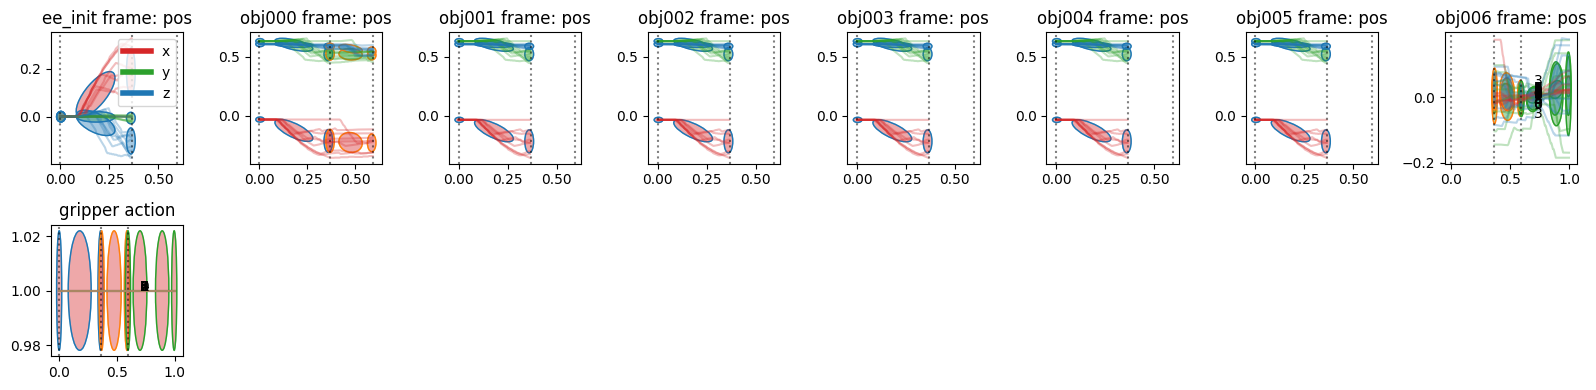

In [ ]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [ ]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-07-21 22:34:57.323 | INFO     |  Fitting AutoTPGMM
2025-07-21 22:34:57.323 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-21 22:34:57.335 | INFO     |  HMM EM ...
2025-07-21 22:34:57.337 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-21 22:34:57.360 | INFO     |  HMM init priors not defined, initializing to uniform
2025-07-21 22:34:57.416 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.99e-01, 9.99e-01, 9.99e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.12e-04, 9.71e-04, 1.24e-03, ..., 1.13e-02, 8.67e-03, 6.91e-03],
         [1.11e-57, 7.56e-56, 5.17e-54, ..., 9.89e-01, 9.91e-01, 9.93e-01]]),
  array([[9.41e-01, 9.26e-01, 9.03e-01, 8.69e-01, 8.16e-01, 7.30e-01,
          6.08e-01, 4.55e-01, 2.96e-01, 1.66e-01, 8.13e-02, 3.55e-02,
          1.42e-02, 5.23e-03, 1.80e-03, 5.27e-04, 1.29e-04, 2.64e-05,
          4.54e-06, 6.57e-07, 7.97e-08, 8.11e-09, 6.86e-10, 1.14e-10,
          1.74e-11, 2.32e-12, 2.63e-13, 2.55e-14, 2.19e-15, 1.71e-16,
          1.27e-17, 9.14e-19, 6.45e-20, 4.49e-21, 3.11e-22, 2.14e-23,
          1.46e-24, 9.32e-01, 9.24e-01, 9.09e-01, 8.85e-01, 8.48e-01,
          7.92e-01, 7.08e-01, 5.92e-01, 4.49e-01, 3.00e-01, 1.75e-01,
          8.92e-02, 4.07e-02, 1.70e-02, 4.62e-03, 1.03e-03, 1.02e-04,
          1.45e-05, 1.72e-06, 1.72e-07, 1.44e-08, 3.17e-10, 5.77e-11,
          9.77e-12, 1.45e-12, 1.84e-13, 1.95e-14, 1.77e-15, 1.44e-16,


2025-07-21 22:34:57.709 | INFO     |  Did not specify time_based, deciding automatically.


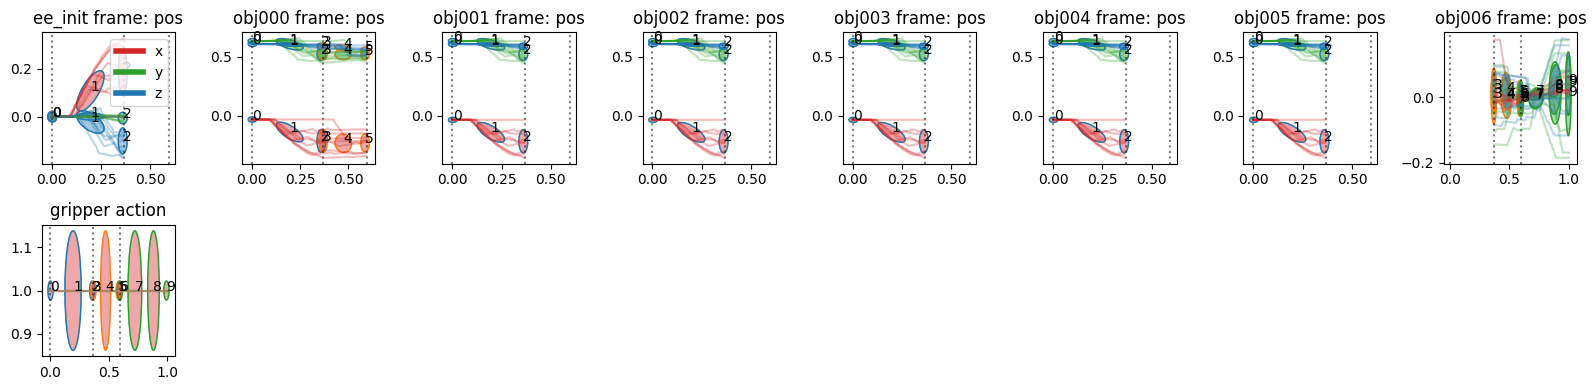

In [ ]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

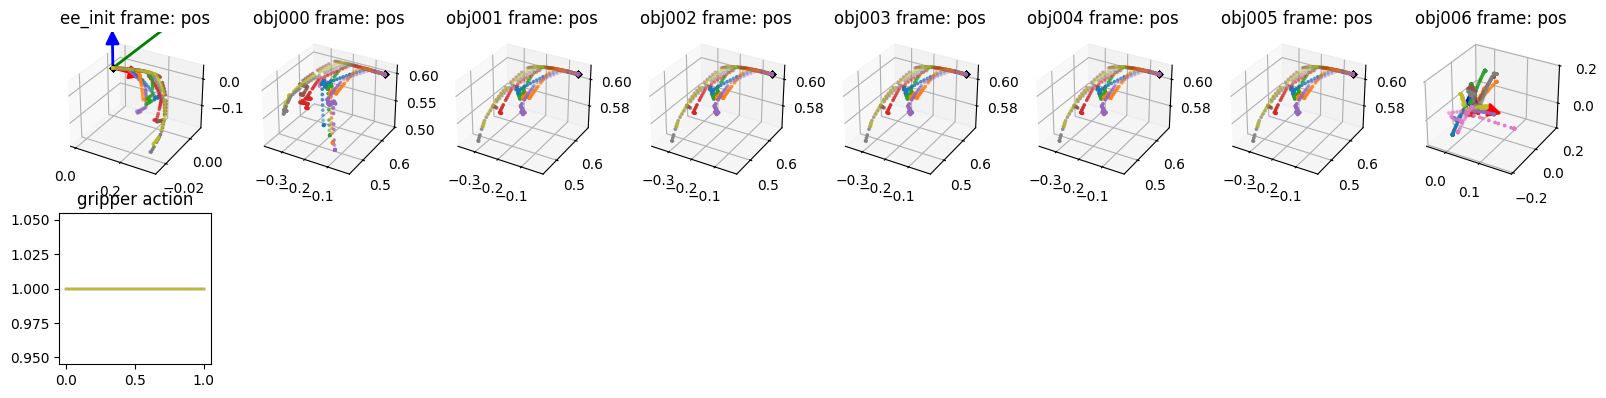

In [ ]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

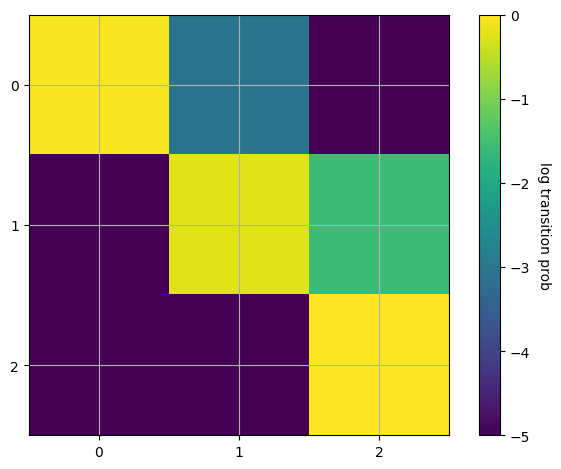

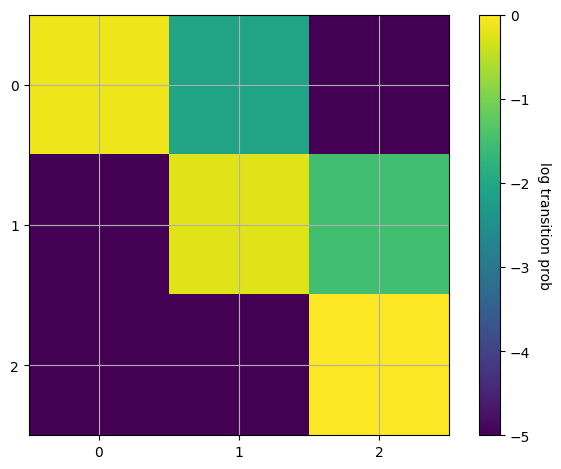

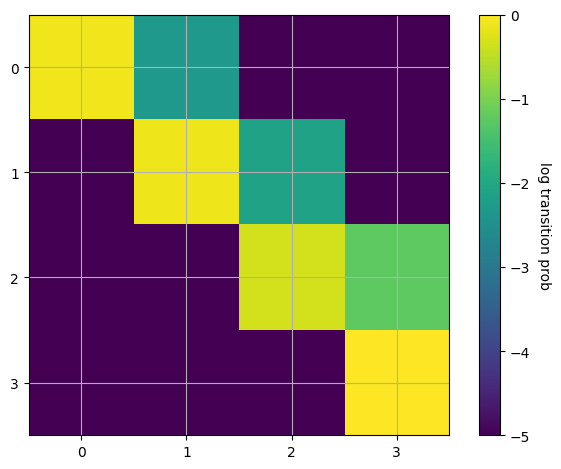

In [ ]:
atpgmm.plot_hmm_transition_matrix()

In [ ]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-07-21 22:35:06.396 | INFO     |  Saving model:


In [ ]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-07-21 22:35:06.677 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-07-21 22:35:06.744 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]))
2025-07-21 22:35:06.744 | INFO     |  Creating partial frame view of demos.
2025-07-21 22:35:06.901 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/9 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-21 22:35:07.290 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/9 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-21 22:35:07.564 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/9 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-21 22:35:07.669 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/9 [00:00<?, ?it/s]

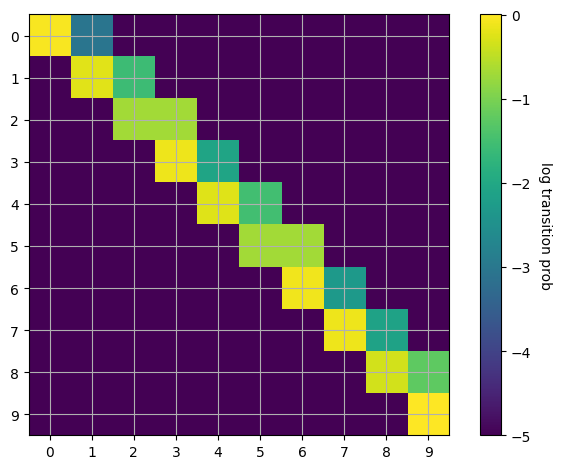

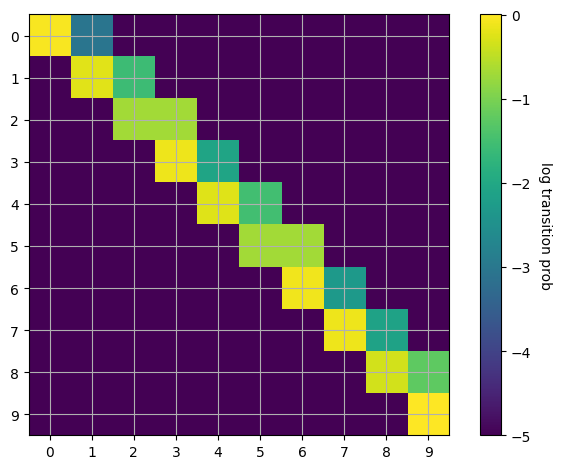

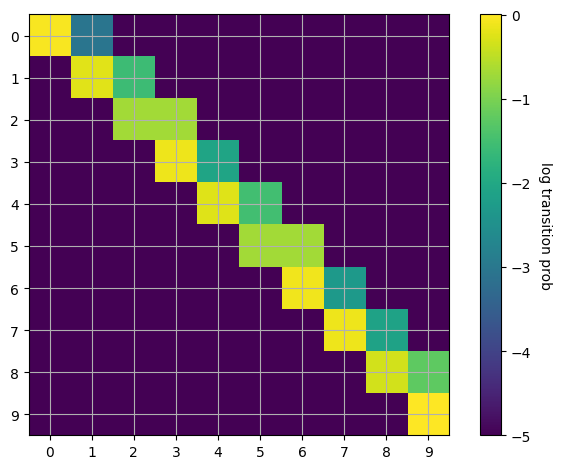

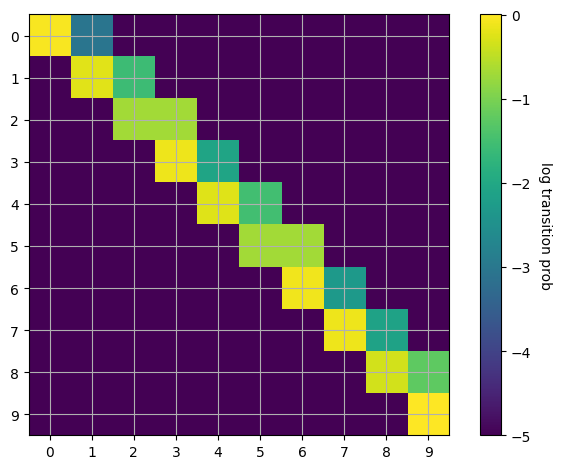

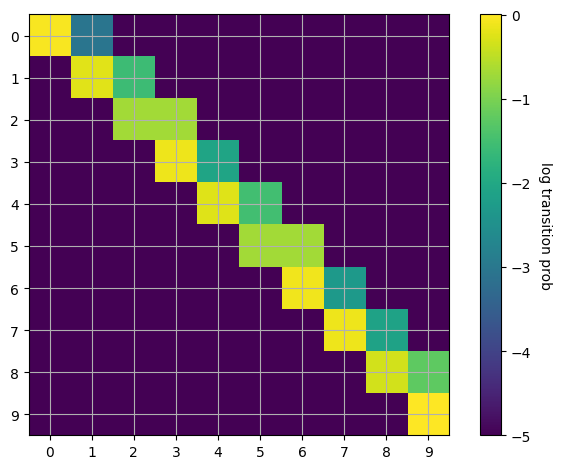

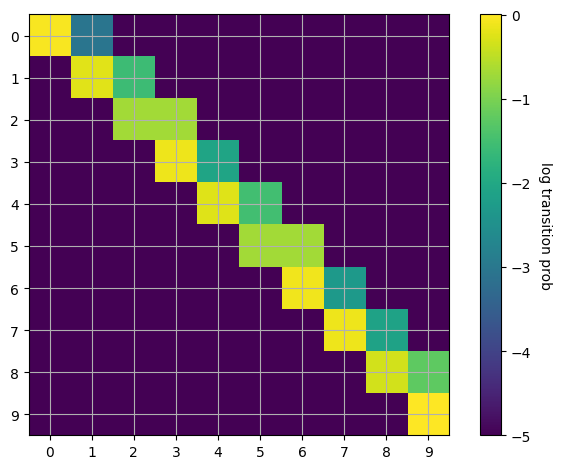

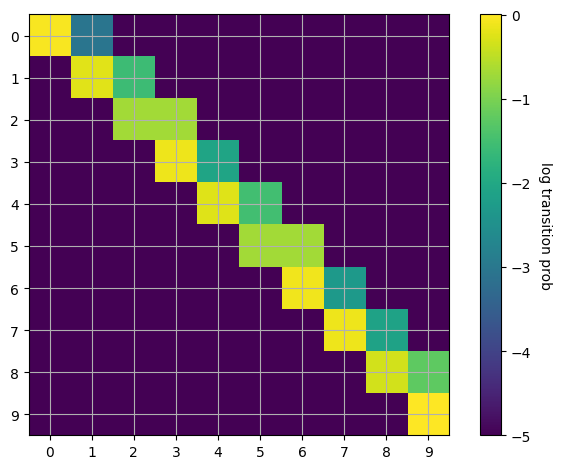

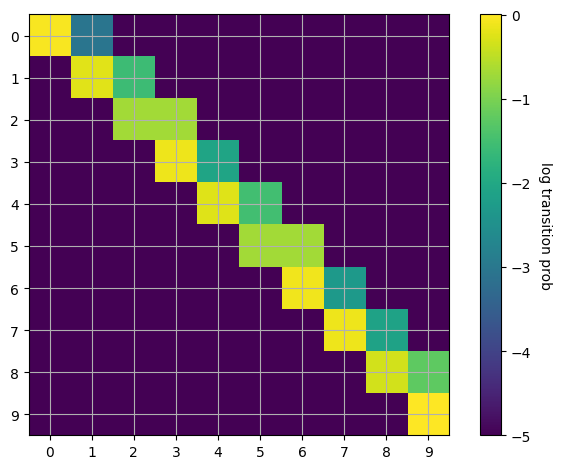

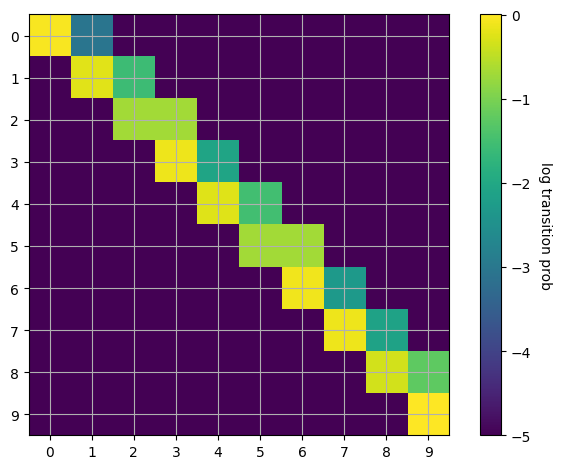

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-07-21 22:35:16.936 | INFO     |  Taking frame origins from demos.


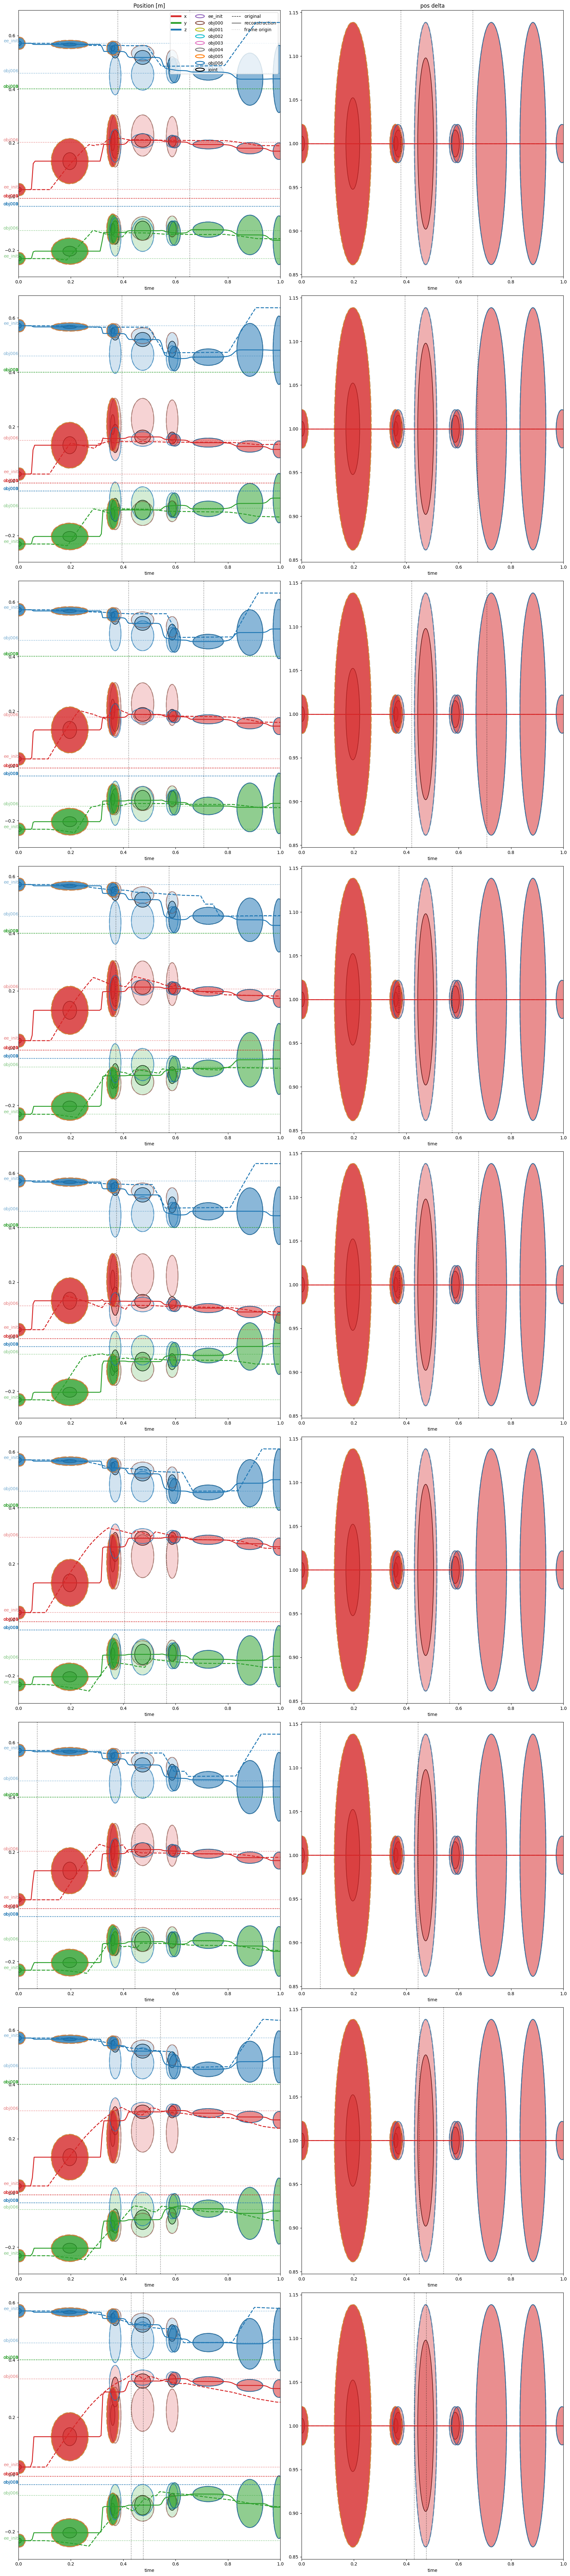

In [ ]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range